In [10]:
import os
import random
import jieba
from gensim import corpora, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# 参数配置
DATA_DIR = '/Users/lh/DL-nlp2025/HW2/jyxstxtqj_downcc'
TOTAL_SAMPLES = 1000
K_TOKEN = 3000
UNIT = 'word'  # 'word' or 'char'
NUM_TOPICS = 100
SEED = 42

# 1. 文本预处理：按 K 个 token 切割
def split_paragraphs(text, k=100, unit='word'):
    text = text.replace('\n', '').strip()
    tokens = list(jieba.cut(text)) if unit == 'word' else list(text)
    return [tokens[i:i+k] for i in range(0, len(tokens) - k + 1, k)]

# 2. 加载数据集，每本小说均匀采样段落
def load_data(data_dir, total_samples=1000, k=100, unit='word'):
    data = []
    labels = []
    files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
    per_file = total_samples // len(files)

    for fname in files:
        path = os.path.join(data_dir, fname)
        with open(path, 'r', encoding='GB18030') as f:
            content = f.read()
        para_tokens = split_paragraphs(content, k=k, unit=unit)
        random.shuffle(para_tokens)
        selected = para_tokens[:per_file]
        data.extend(selected)
        labels.extend([fname] * len(selected))
    
    return data, labels

# 3. 训练 LDA 并得到主题向量
def get_lda_vectors(texts, num_topics=50):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=SEED)

    topic_vectors = []
    for doc in corpus:
        dist = lda.get_document_topics(doc, minimum_probability=0)
        vec = [prob for _, prob in sorted(dist, key=lambda x: x[0])]
        topic_vectors.append(vec)
    
    return np.array(topic_vectors)

# 4. 分类 + 10 折交叉验证
def cross_validate(X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    acc_list = []
    for train_idx, test_idx in kf.split(X):
        clf = RandomForestClassifier(random_state=SEED)
        clf.fit(X[train_idx], y[train_idx])
        pred = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], pred)
        acc_list.append(acc)
    return acc_list

# === 主程序 ===
if __name__ == '__main__':
    print(f"加载数据中（单位={UNIT}，每段K={K_TOKEN}个token）...")
    texts, labels = load_data(DATA_DIR, TOTAL_SAMPLES, k=K_TOKEN, unit=UNIT)
    
    print(f"使用LDA生成主题分布（T={NUM_TOPICS}）...")
    lda_vecs = get_lda_vectors(texts, num_topics=NUM_TOPICS)

    print("开始分类（10折交叉验证）...")
    accs = cross_validate(lda_vecs, np.array(labels))
    print("各折准确率：", [f"{a:.4f}" for a in accs])
    print(f"平均准确率：{np.mean(accs):.4f}")


加载数据中（单位=word，每段K=3000个token）...
使用LDA生成主题分布（T=100）...
开始分类（10折交叉验证）...
各折准确率： ['0.7324', '0.6286', '0.6143', '0.7714', '0.7143', '0.6143', '0.5714', '0.6571', '0.6429', '0.6000']
平均准确率：0.6547


Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/83/ytqbvn616v5_nmwr5ckzpd_h0000gn/T/jieba.cache
Loading model cost 0.620 seconds.
Prefix dict has been built successfully.


[word] K=20 T=10
[word] K=20 T=30
[word] K=20 T=50
[word] K=20 T=70
[word] K=20 T=100
[word] K=100 T=10
[word] K=100 T=30
[word] K=100 T=50
[word] K=100 T=70
[word] K=100 T=100
[word] K=500 T=10
[word] K=500 T=30
[word] K=500 T=50
[word] K=500 T=70
[word] K=500 T=100
[word] K=1000 T=10
[word] K=1000 T=30
[word] K=1000 T=50
[word] K=1000 T=70
[word] K=1000 T=100
[word] K=3000 T=10
[word] K=3000 T=30
[word] K=3000 T=50
[word] K=3000 T=70
[word] K=3000 T=100
[char] K=20 T=10
[char] K=20 T=30
[char] K=20 T=50
[char] K=20 T=70
[char] K=20 T=100
[char] K=100 T=10
[char] K=100 T=30
[char] K=100 T=50
[char] K=100 T=70
[char] K=100 T=100
[char] K=500 T=10
[char] K=500 T=30
[char] K=500 T=50
[char] K=500 T=70
[char] K=500 T=100
[char] K=1000 T=10
[char] K=1000 T=30
[char] K=1000 T=50
[char] K=1000 T=70
[char] K=1000 T=100
[char] K=3000 T=10
[char] K=3000 T=30
[char] K=3000 T=50
[char] K=3000 T=70
[char] K=3000 T=100


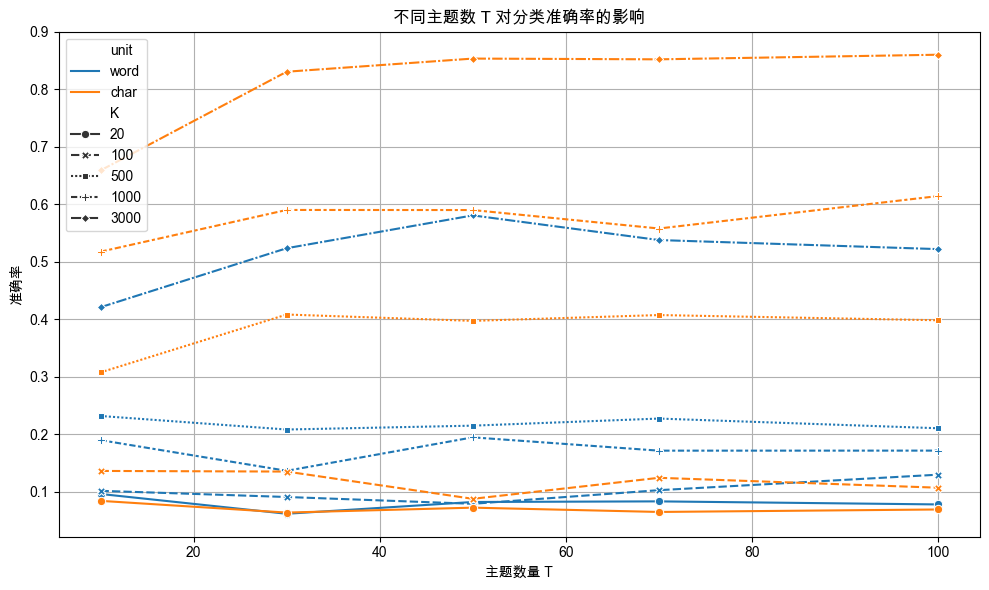

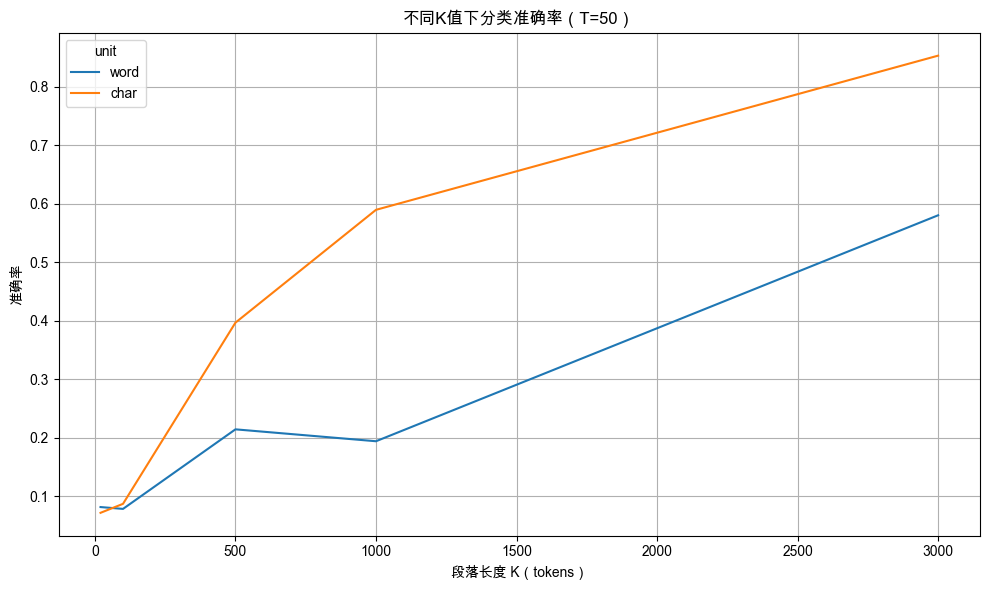

In [1]:
import os
import random
import jieba
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm
plt.rcParams['font.family'] = 'Arial Unicode MS'
# 参数
DATA_DIR = '/Users/lh/DL-nlp2025/HW2/jyxstxtqj_downcc'
TOTAL_SAMPLES = 1000
SEED = 42
T_LIST = [10, 30, 50, 70, 100]
K_LIST = [20, 100, 500, 1000, 3000]
UNIT_LIST = ['word', 'char']


# 分词或分字
def split_paragraphs(text, k=100, unit='word'):
    text = text.replace('\n', '').strip()
    tokens = list(jieba.cut(text)) if unit == 'word' else list(text)
    return [tokens[i:i+k] for i in range(0, len(tokens) - k + 1, k)]

# 加载数据
def load_data(data_dir, total_samples=1000, k=100, unit='word'):
    data = []
    labels = []
    files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
    per_file = total_samples // len(files)

    for fname in files:
        path = os.path.join(data_dir, fname)
        try:
            with open(path, 'r', encoding="GB18030", errors='ignore') as f:
                content = f.read()
            paras = split_paragraphs(content, k=k, unit=unit)
            random.shuffle(paras)
            selected = paras[:per_file]
            data.extend(selected)
            labels.extend([fname] * len(selected))
        except Exception as e:
            print(f"读取失败: {fname}, 错误: {e}")
    
    return data, labels

# LDA向量生成
def get_lda_vectors(texts, num_topics=50):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=SEED)
    topic_vectors = []
    for doc in corpus:
        dist = lda.get_document_topics(doc, minimum_probability=0)
        vec = [prob for _, prob in sorted(dist, key=lambda x: x[0])]
        topic_vectors.append(vec)
    return np.array(topic_vectors)

# 10折交叉验证
def cross_validate(X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    acc_list = []
    for train_idx, test_idx in kf.split(X):
        clf = RandomForestClassifier(random_state=SEED)
        clf.fit(X[train_idx], y[train_idx])
        pred = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], pred)
        acc_list.append(acc)
    return np.mean(acc_list)

# 主实验流程
results = []

for unit in UNIT_LIST:
    for k in K_LIST:
        try:
            texts, labels = load_data(DATA_DIR, TOTAL_SAMPLES, k=k, unit=unit)
            if len(texts) == 0: continue
            for T in T_LIST:
                print(f"[{unit}] K={k} T={T}")
                lda_vecs = get_lda_vectors(texts, num_topics=T)
                acc = cross_validate(lda_vecs, np.array(labels))
                results.append({
                    'unit': unit,
                    'K': k,
                    'T': T,
                    'acc': acc
                })
        except Exception as e:
            print(f"跳过 unit={unit}, K={k}, T={T}，错误：{e}")

# === 可视化 ===
import pandas as pd
df = pd.DataFrame(results)

# 图1：不同T下的准确率（分别画词和字）
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='T', y='acc', hue='unit', style='K', markers=True)
plt.title('不同主题数 T 对分类准确率的影响')
plt.ylabel('准确率')
plt.xlabel('主题数量 T')
plt.grid(True)
plt.tight_layout()
plt.show()

# 图2：不同K下的准确率（固定T=50）
plt.figure(figsize=(10, 6))
df_t50 = df[df['T'] == 50]
sns.lineplot(data=df_t50, x='K', y='acc', hue='unit', markers=True)
plt.title('不同K值下分类准确率（T=50）')
plt.ylabel('准确率')
plt.xlabel('段落长度 K（tokens）')
plt.grid(True)
plt.tight_layout()
plt.show()


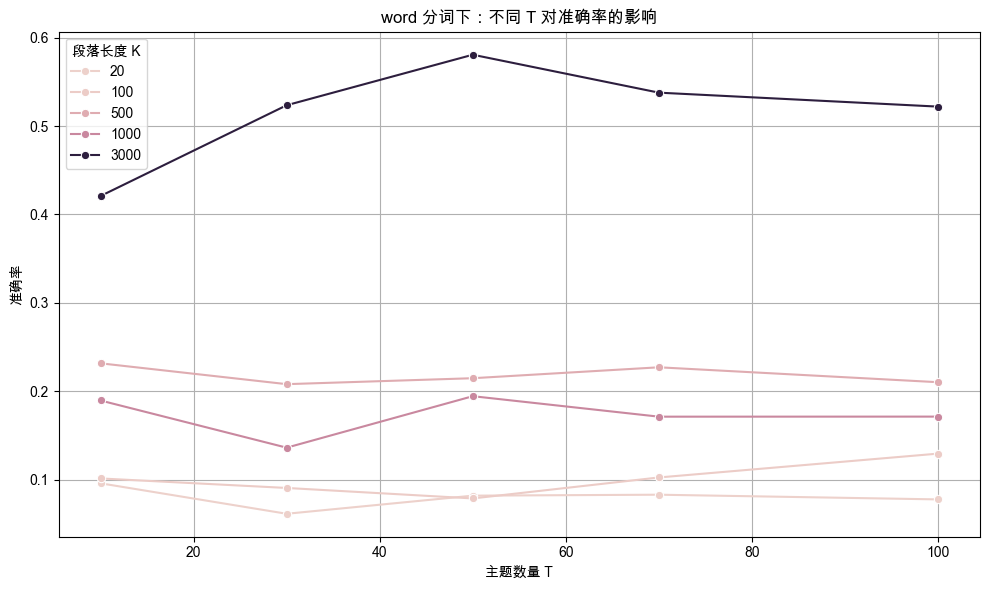

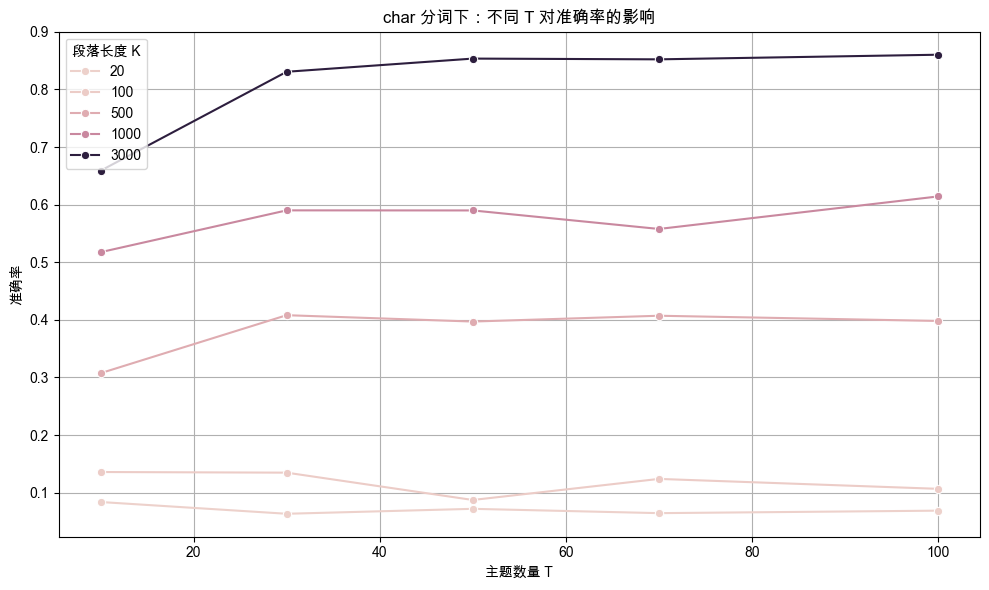

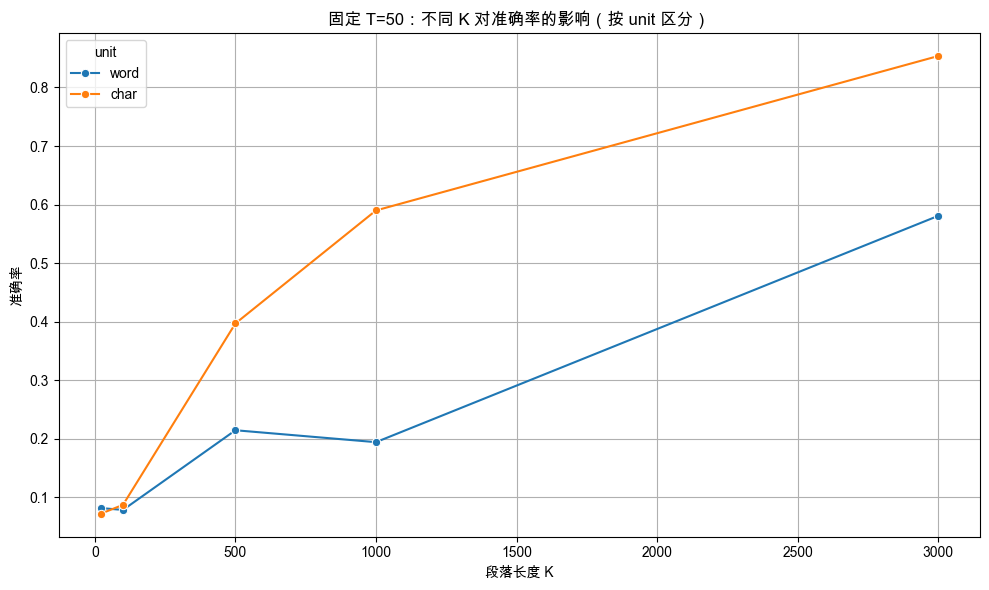

In [2]:
plt.rcParams['font.family'] = 'Arial Unicode MS'
for unit_type in ['word', 'char']:
    plt.figure(figsize=(10, 6))
    df_unit = df[df['unit'] == unit_type]
    sns.lineplot(data=df_unit, x='T', y='acc', hue='K', marker='o')
    plt.title(f'{unit_type} 分词下：不同 T 对准确率的影响')
    plt.ylabel('准确率')
    plt.xlabel('主题数量 T')
    plt.legend(title='段落长度 K')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(10, 6))
df_t50 = df[df['T'] == 50]
sns.lineplot(data=df_t50, x='K', y='acc', hue='unit', marker='o')
plt.title('固定 T=50：不同 K 对准确率的影响（按 unit 区分）')
plt.ylabel('准确率')
plt.xlabel('段落长度 K')
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

# 假设 results 已经是一个包含 unit/K/T/acc 的列表
df = pd.DataFrame(results)
df = df.sort_values(by=['unit', 'K', 'T'])

# 对于每个 unit（char 和 word），生成一个 pivot 表，并输出为 LaTeX
for unit in ['char', 'word']:
    print(f"\n% ========== LaTeX Table for unit: {unit} ==========\n")
    unit_df = df[df['unit'] == unit]
    pivot_table = unit_df.pivot(index='K', columns='T', values='acc')
    latex_code = pivot_table.to_latex(float_format="%.4f", caption=f"LDA Classification Accuracy (unit={unit})", label=f"tab:lda_{unit}")
    print(latex_code)



% ========== LaTeX Table for unit: char ==========

\begin{table}
\caption{LDA Classification Accuracy (unit=char)}
\label{tab:lda_char}
\begin{tabular}{lrrrrr}
\toprule
T & 10 & 30 & 50 & 70 & 100 \\
K &  &  &  &  &  \\
\midrule
20 & 0.0838 & 0.0634 & 0.0720 & 0.0645 & 0.0688 \\
100 & 0.1359 & 0.1348 & 0.0873 & 0.1239 & 0.1067 \\
500 & 0.3074 & 0.4081 & 0.3971 & 0.4072 & 0.3981 \\
1000 & 0.5175 & 0.5901 & 0.5900 & 0.5578 & 0.6143 \\
3000 & 0.6589 & 0.8307 & 0.8536 & 0.8523 & 0.8603 \\
\bottomrule
\end{tabular}
\end{table}


% ========== LaTeX Table for unit: word ==========

\begin{table}
\caption{LDA Classification Accuracy (unit=word)}
\label{tab:lda_word}
\begin{tabular}{lrrrrr}
\toprule
T & 10 & 30 & 50 & 70 & 100 \\
K &  &  &  &  &  \\
\midrule
20 & 0.0958 & 0.0613 & 0.0818 & 0.0829 & 0.0776 \\
100 & 0.1013 & 0.0905 & 0.0787 & 0.1024 & 0.1294 \\
500 & 0.2315 & 0.2079 & 0.2147 & 0.2270 & 0.2102 \\
1000 & 0.1895 & 0.1361 & 0.1943 & 0.1712 & 0.1712 \\
3000 & 0.4208 & 0.5235 & 0.580